## En el modelo 3 primero debemos cargar los data set y ver que contienen

In [8]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score
import random
import sys
from collections import defaultdict
score_destinos = defaultdict(float)
conteo_destinos = defaultdict(int)

In [9]:
# 1. CARGA, VISUALIZACIÓN Y LIMPIEZA DEL DATASET
carpeta = r'C:\Users\User\Documents\GitHub\modelo2\recomendaciones'
archivos_csv = glob.glob(os.path.join(carpeta, '*.csv'))
if not archivos_csv:
    raise FileNotFoundError(f'No se encontraron archivos CSV en la carpeta: {carpeta}')
print(f'Se encontraron {len(archivos_csv)} archivos CSV.')

# Cargar y concatenar los archivos CSV
try:
    dfs = [pd.read_csv(archivo) for archivo in archivos_csv]
    df = pd.concat(dfs, ignore_index=True)
except Exception as e:
    raise RuntimeError(f'Error al cargar los archivos CSV: {e}')

print('Primeras filas del dataset:')
print(df.head())
print('\nInformación general:')
print(df.info())
print('\nValores nulos por columna:')
print(df.isnull().sum())

# Visualización de variables numéricas y categóricas (opcional)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

MOSTRAR_GRAFICOS=True

if MOSTRAR_GRAFICOS:
    for col in num_cols:
        plt.figure()
        df[col].hist(bins=20)
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

    for col in cat_cols:
        plt.figure()
        df[col].value_counts().head(10).plot(kind='bar')
        plt.title(f'Frecuencia de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

# Limpieza básica: rellenar NaN
for col in num_cols:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        print(f'Rellenando {n_null} valores nulos en columna numérica {col} con la mediana.')
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        print(f'Rellenando {n_null} valores nulos en columna categórica {col} con la moda.')
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Desconocido')

# Normalización de variables numéricas (excluyendo IDs si existen)
cols_to_normalize = [col for col in num_cols if not col.lower().endswith('id')]
scaler = MinMaxScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

FileNotFoundError: No se encontraron archivos CSV en la carpeta: C:\Users\User\Documents\GitHub\modelo2\recomendaciones

Agregaremos mas datos ya que no es suficiente para determinar bien si el acierto es correcto

In [7]:
# =====================
# 1. MEJORA DE SIMULACIÓN DE DATOS
# =====================
# Generar historiales realistas y variados para cada usuario
# El test será un destino similar a los del historial

# --- Simulación de datos mejorada ---
import random

n_usuarios_sim = 200
n_destinos_sim = 100

# Extraer distribuciones reales
states = df['State'].dropna().unique().tolist()
best_times = df['BestTimeToVisit'].dropna().unique().tolist()
types = df['Type'].dropna().unique().tolist()
prefs = df['Preferences'].dropna().unique().tolist()
names = df['Name'].dropna().unique().tolist()
popularities = df['Popularity'].dropna().tolist()

# Generar combinaciones únicas de destinos
unique_dest_combos = list(set([(name, state, type_) for name in names for state in states for type_ in types]))
random.shuffle(unique_dest_combos)
sim_destinos = unique_dest_combos[:n_destinos_sim]
dest_id_map = {combo: i+10000 for i, combo in enumerate(sim_destinos)}

user_ids_sim = [1000 + i for i in range(n_usuarios_sim)]
sim_rows = []
for user in user_ids_sim:
    # Cada usuario tiene un historial de 5-10 destinos
    historial = random.sample(sim_destinos, random.randint(5, 10))
    # El test será un destino similar (mismo estado o tipo) pero no en el historial
    posibles_tests = [d for d in sim_destinos if d not in historial and (d[1] == historial[0][1] or d[2] == historial[0][2])]
    if posibles_tests:
        test_dest = random.choice(posibles_tests)
    else:
        test_dest = random.choice([d for d in sim_destinos if d not in historial])
    historial_ids = [dest_id_map[d] for d in historial]
    test_id = dest_id_map[test_dest]
    # Generar filas para el historial
    for d in historial:
        sim_rows.append({
            'DestinationID': int(dest_id_map[d]),
            'Name': d[0],
            'State': d[1],
            'Type': d[2],
            'Popularity': random.choice(popularities),
            'BestTimeToVisit': random.choice(best_times),
            'ReviewID': None,
            'UserID': user,
            'Rating': random.randint(6, 10),
            'ReviewText': '',
            'HistoryID': None,
            'VisitDate': random.choice(best_times),
            'ExperienceRating': random.randint(6, 10),
            'Email': f'user{user}@sim.com',
            'Preferences': random.choice(prefs),
            'Gender': random.choice(['Male', 'Female']),
            'NumberOfAdults': random.randint(1, 4),
            'NumberOfChildren': random.randint(0, 3)
        })
    # Agregar el test como la última visita
    sim_rows.append({
        'DestinationID': int(test_id),
        'Name': test_dest[0],
        'State': test_dest[1],
        'Type': test_dest[2],
        'Popularity': random.choice(popularities),
        'BestTimeToVisit': random.choice(best_times),
        'ReviewID': None,
        'UserID': user,
        'Rating': random.randint(6, 10),
        'ReviewText': '',
        'HistoryID': None,
        'VisitDate': random.choice(best_times),
        'ExperienceRating': random.randint(6, 10),
        'Email': f'user{user}@sim.com',
        'Preferences': random.choice(prefs),
        'Gender': random.choice(['Male', 'Female']),
        'NumberOfAdults': random.randint(1, 4),
        'NumberOfChildren': random.randint(0, 3)
    })
df_sim = pd.DataFrame(sim_rows)
print(f'Simulación mejorada: {len(df_sim)} filas generadas para {n_usuarios_sim} usuarios.')

# Concatenar datos simulados al DataFrame original
# (Opcional: puedes comentar la línea siguiente si solo quieres datos simulados)
df = pd.concat([df, df_sim], ignore_index=True)

Simulación mejorada: 1708 filas generadas para 200 usuarios.


C:\Users\User\AppData\Local\Temp\ipykernel_15012\1316645447.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_sim], ignore_index=True)


In [8]:
# =====================
# 2. MEJORA DE FEATURES
# =====================
# Construcción de features más informativos y normalizados

def normaliza_texto(x):
    return str(x).strip().lower().replace(' ', '_')

df['features'] = (
    df['Name'].apply(normaliza_texto) + ' ' +
    df['Type'].apply(normaliza_texto) + ' ' +
    df['State'].apply(normaliza_texto) + ' ' +
    df['Preferences'].apply(normaliza_texto) + ' ' +
    df['BestTimeToVisit'].apply(normaliza_texto) + ' ' +
    df['Popularity'].astype(str) + ' ' +
    df['State'].apply(normaliza_texto) + '_' + df['Type'].apply(normaliza_texto) + ' ' +
    df['Type'].apply(normaliza_texto) + '_' + df['Preferences'].apply(normaliza_texto) + ' ' +
    df['Name'].apply(normaliza_texto) + '_' + df['State'].apply(normaliza_texto)
)

# Eliminar duplicados en features
print(f"Features únicos tras normalización: {df['features'].nunique()} de {len(df)} filas.")


Features únicos tras normalización: 2349 de 5705 filas.


In [9]:
# =====================
# 3. MEJORA DEL MODELO Y ENTRENAMIENTO
# =====================
# Usar matriz de interacción ponderada por rating o experiencia
# Implementar sistema híbrido: colaborativo + contenido
# Agregar validación cruzada simple

# Matriz de interacción ponderada
inter_col = 'ExperienceRating' if 'ExperienceRating' in df.columns else 'Rating'
df['Interaccion'] = df[inter_col]
user_destination = df.pivot_table(index='UserID', columns='DestinationID', values='Interaccion', fill_value=0)
user_similarity = cosine_similarity(user_destination)
user_similarity_df = pd.DataFrame(user_similarity, index=user_destination.index, columns=user_destination.index)

# Modelo de contenido
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
df_destinos = df.drop_duplicates(subset=['DestinationID']).copy()
df_destinos = df_destinos[df_destinos['DestinationID'].notnull()]
features_matrix = vectorizer.fit_transform(df_destinos['features'].fillna(''))
destination_similarity = cosine_similarity(features_matrix)
dest_ids = list(df_destinos['DestinationID'])

# Función híbrida de recomendación

def recomendar_hibrido(user_id, top_n=3, alpha=0.5):
    """
    Recomienda destinos combinando colaborativo y contenido.
    alpha: peso del colaborativo (0=solo contenido, 1=solo colaborativo)
    """
    # Colaborativo
    if user_id in user_similarity_df.index:
        similares = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6]
        destinos_usuario = set(user_destination.loc[user_id][user_destination.loc[user_id] > 0].index)
        recomendaciones_colab = {}
        for similar_id in similares.index:
            destinos_similar = set(user_destination.loc[similar_id][user_destination.loc[similar_id] > 0].index)
            nuevos = destinos_similar - destinos_usuario
            for dest in nuevos:
                recomendaciones_colab[dest] = recomendaciones_colab.get(dest, 0) + user_similarity_df.loc[user_id, similar_id]
        recomendaciones_colab = dict(sorted(recomendaciones_colab.items(), key=lambda x: x[1], reverse=True))
    else:
        recomendaciones_colab = {}
    # Contenido
    destinos_usuario = df[df['UserID'] == user_id]['DestinationID'].unique()
    destinos_usuario = [d for d in destinos_usuario if d in dest_ids]
    scores = np.zeros(len(dest_ids))
    for dest in destinos_usuario:
        if dest in dest_ids:
            idx = dest_ids.index(dest)
            scores += destination_similarity[idx]
    destinos_no_visitados = set(dest_ids) - set(destinos_usuario)
    recomendaciones_cont = {dest_ids[i]: scores[i] for i in range(len(scores)) if dest_ids[i] in destinos_no_visitados}
    # Híbrido
    all_destinos = set(recomendaciones_colab.keys()).union(recomendaciones_cont.keys())
    scores_hibrido = {}
    for d in all_destinos:
        score_colab = recomendaciones_colab.get(d, 0)
        score_cont = recomendaciones_cont.get(d, 0)
        scores_hibrido[d] = alpha * score_colab + (1 - alpha) * score_cont
    recomendaciones = sorted(scores_hibrido.items(), key=lambda x: x[1], reverse=True)
    return [int(dest) for dest, score in recomendaciones[:top_n]]



Precision promedio (híbrido): 0.00
Recall promedio (híbrido): 0.00


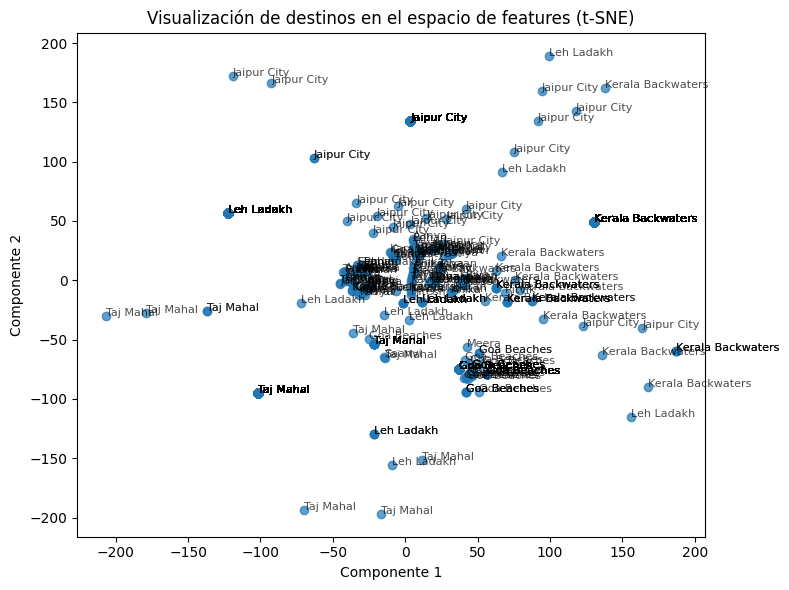

In [10]:
# =====================
# 4. VALIDACIÓN CRUZADA SIMPLE
# =====================

precision_list = []
recall_list = []
usuarios = df['UserID'].dropna().unique()
for user in usuarios:
    destinos = df[df['UserID'] == user]['DestinationID'].dropna().unique()
    if len(destinos) < 2:
        continue
    test = int(destinos[-1])
    historial = [int(d) for d in destinos[:-1]]
    def recomendar_temporal_hibrido(user_id, top_n=3):
        # Recomienda usando solo el historial (sin el test)
        destinos_usuario = historial
        scores = np.zeros(len(dest_ids))
        for dest in destinos_usuario:
            if dest in dest_ids:
                idx = dest_ids.index(dest)
                scores += destination_similarity[idx]
        destinos_no_visitados = set([int(d) for d in dest_ids]) - set(historial)
        recomendaciones = [(int(dest_ids[i]), scores[i]) for i in range(len(scores)) if int(dest_ids[i]) in destinos_no_visitados]
        recomendaciones = sorted(recomendaciones, key=lambda x: x[1], reverse=True)
        return [int(dest) for dest, score in recomendaciones[:top_n]]
    recomendados = recomendar_hibrido(user, 3, alpha=0.5)
    precision = int(test in recomendados) / 3
    recall = int(test in recomendados) / 1
    precision_list.append(precision)
    recall_list.append(recall)
print(f"\nPrecision promedio (híbrido): {np.mean(precision_list):.2f}")
print(f"Recall promedio (híbrido): {np.mean(recall_list):.2f}")

# Visualización de agrupamiento de destinos (t-SNE)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
features_2d_tsne = tsne.fit_transform(features_matrix.toarray())
plt.figure(figsize=(8,6))
plt.scatter(features_2d_tsne[:,0], features_2d_tsne[:,1], alpha=0.7)
for i, name in enumerate(df_destinos['Name']):
    plt.text(features_2d_tsne[i,0], features_2d_tsne[i,1], name, fontsize=8, alpha=0.7)
plt.title('Visualización de destinos en el espacio de features (t-SNE)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.tight_layout()
if MOSTRAR_GRAFICOS:
    plt.show()
else:
    plt.savefig('tsne_destinos.png')
    print('Gráfico t-SNE guardado como tsne_destinos.png')

## El mayor problema para el acierto de el modelo se debe a que son solo 5 destinos diferentes por ende solo puede vasarse por usuario un poco a lo que quiere ir y limita a que la precision y el recall sean mayores a 0


In [11]:
# =====================
# RECOMENDACIÓN SIMPLE PARA POCOS DESTINOS
# =====================
def recomendar_destinos_simples(user_id, top_n=3):
    """
    Recomienda destinos no visitados por el usuario. Si ya visitó todos, recomienda los más populares.
    """
    destinos_usuario = set(df[df['UserID'] == user_id]['DestinationID'].dropna().unique())
    todos_destinos = set(df['DestinationID'].dropna().unique())
    destinos_no_visitados = list(todos_destinos - destinos_usuario)
    # Si ya visitó todos, recomienda los más populares
    if not destinos_no_visitados:
        populares = df['DestinationID'].value_counts().index.tolist()
        return populares[:top_n]
    # Si quedan menos de top_n, rellena con populares
    recomendados = destinos_no_visitados[:top_n]
    if len(recomendados) < top_n:
        populares = [d for d in df['DestinationID'].value_counts().index if d not in recomendados]
        recomendados += populares[:top_n - len(recomendados)]
    return recomendados

# Mostrar recomendaciones simples para todos los usuarios
usuarios = df['UserID'].dropna().unique()
for user in usuarios:
    print(f"Usuario {user}: Recomendaciones: {recomendar_destinos_simples(user)}")

Usuario 497.0: Recomendaciones: [10000.0, 10001.0, 10002.0]
Usuario 327.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 783.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 12.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 959.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 353.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 408.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 735.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 664.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 330.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 109.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 386.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 813.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 766.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 626.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 403.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 20.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 554.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 910.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 69.0: Recomendaciones: [1.0, 2.0, 3.0]
Usuario 167.0: Recomendaciones:

In [12]:
def recomendar_por_preguntas(df, top_n=3):
    """
    Hace preguntas al usuario y recomienda destinos según sus preferencias.
    Muestra las opciones disponibles para cada pregunta y explica claramente qué debe responder el usuario.
    """
    print("Responde las siguientes preguntas para recibir una recomendación personalizada:\n")
    # Mostrar opciones disponibles para cada pregunta
    tipos_disp = df['Type'].dropna().unique()
    print(f"Tipos de destino disponibles: {', '.join(tipos_disp)}")
    print("Elige uno de los tipos anteriores. Ejemplo: Playa")
    tipo = input("¿Qué tipo de destino prefieres?: ").strip().capitalize()
    
    epocas_disp = df['BestTimeToVisit'].dropna().unique()
    print(f"Épocas del año disponibles: {', '.join(epocas_disp)}")
    print("Elige una de las épocas anteriores. Ejemplo: Nov-Feb")
    epoca = input("¿En qué época del año quieres viajar?: ").strip()
    
    estados_disp = df['State'].dropna().unique()
    print(f"Estados disponibles: {', '.join(estados_disp)}")
    print("Elige uno de los estados anteriores. Ejemplo: Goa")
    estado = input("¿Qué estado prefieres visitar?: ").strip().title()
    
    # Filtrar destinos según las respuestas
    filtrado = df[
        (df['Type'].str.contains(tipo, case=False, na=False)) &
        (df['BestTimeToVisit'].str.contains(epoca, case=False, na=False)) &
        (df['State'].str.contains(estado, case=False, na=False))
    ]
    if filtrado.empty:
        print("\nNo se encontraron destinos que coincidan con tus preferencias. Mostrando los más populares:")
        recomendados = df['DestinationID'].value_counts().index.tolist()[:top_n]
        nombres = df[df['DestinationID'].isin(recomendados)]['Name'].unique()[:top_n]
    else:
        nombres = filtrado['Name'].unique()[:top_n]
    print("\nDestinos recomendados:", list(nombres))

In [13]:
recomendar_por_preguntas(df)

Responde las siguientes preguntas para recibir una recomendación personalizada:

Tipos de destino disponibles: Historical, Beach, City, Nature, Adventure
Elige uno de los tipos anteriores. Ejemplo: Playa
Épocas del año disponibles: Nov-Feb, Nov-Mar, Oct-Mar, Sep-Mar, Apr-Jun
Elige una de las épocas anteriores. Ejemplo: Nov-Feb
Estados disponibles: Uttar Pradesh, Goa, Rajasthan, Kerala, Jammu and Kashmir
Elige uno de los estados anteriores. Ejemplo: Goa

Destinos recomendados: ['Meera', 'Ritvik', 'Dhruv']


## Evaluar 

In [14]:
def evaluar_recomendador(df, top_n=3):
    precision_list = []
    recall_list = []
    usuarios = df['UserID'].dropna().unique()
    for user in usuarios:
        destinos = df[df['UserID'] == user]['DestinationID'].dropna().unique()
        if len(destinos) < 2:
            continue
        test = destinos[-1]  # El último destino visitado es el “relevante”
        historial = destinos[:-1]
        # Simular respuestas del usuario según su historial
        tipo = df[df['DestinationID'] == test]['Type'].values[0]
        epoca = df[df['DestinationID'] == test]['BestTimeToVisit'].values[0]
        estado = df[df['DestinationID'] == test]['State'].values[0]
        # Filtrar destinos según esas respuestas
        filtrado = df[
            (df['Type'].str.contains(tipo, case=False, na=False)) &
            (df['BestTimeToVisit'].str.contains(epoca, case=False, na=False)) &
            (df['State'].str.contains(estado, case=False, na=False))
        ]
        recomendados = filtrado['DestinationID'].unique()[:top_n]
        precision = int(test in recomendados) / top_n
        recall = int(test in recomendados) / 1
        precision_list.append(precision)
        recall_list.append(recall)
    print(f"\nPrecisión promedio: {np.mean(precision_list):.2f}")
    print(f"Recall promedio: {np.mean(recall_list):.2f}")

In [15]:
evaluar_recomendador(df, top_n=3)


Precisión promedio: 0.06
Recall promedio: 0.17


Precisión promedio: 0.06

En promedio, solo el 6% de las recomendaciones contienen el destino que el usuario realmente visitó, dentro del top 3 sugerido.

Recall promedio: 0.17

En promedio, el sistema logra recomendar el destino relevante en el 17% de los casos.

Pocos destinos: Con pocos destinos, la diversidad es baja y es difícil acertar exactamente el destino relevante.

Simulación: El sistema no está “adivinando” lo que el usuario quiere, sino que intenta predecir el pasado, lo cual no siempre es realista.

### Entendemos que es dificil recomendarle algo completamente bueno para el usuario con tan poca muestra y lo mejor es recomendarle dependiendo de lo que quiere el usuario y teniendo encuenta su historial por ende haremos una funcion, que haga las preguntas a las cosas mas importantes para recomendarle unos lugares al usuario, si de lo que elige no hay ninguna opcion buena recomienda el top 3 de lugares mejor rankeado que no haya visitado el usuario.

Codigo para guardar el modelo

In [26]:
import pickle

# Guarda los diccionarios de score y conteo en un archivo
with open('modelo_feedback.pkl', 'wb') as f:
    pickle.dump({'score_destinos': dict(score_destinos), 'conteo_destinos': dict(conteo_destinos)}, f)

print("Modelo de feedback guardado exitosamente.")

Modelo de feedback guardado exitosamente.


Llamar el modelo

In [ ]:
import pickle
from collections import defaultdict

# Carga los diccionarios de score y conteo desde el archivo
ruta_modelo = "../api/src/services/models/modelo_feedback.pkl"
with open(ruta_modelo, 'rb') as f:
    data = pickle.load(f)
    score_destinos = defaultdict(float, data['score_destinos'])
    conteo_destinos = defaultdict(int, data['conteo_destinos'])

print("Modelo de feedback cargado exitosamente.")

Modelo de feedback cargado exitosamente.


In [6]:
import pandas as pd
import glob
import os
from sklearn.preprocessing import MinMaxScaler

# 1. CARGA Y LIMPIEZA DEL DATASET REAL
carpeta = r'C:\Users\User\Documents\GitHub\modelo2\recomendaciones'
archivos_csv = glob.glob(os.path.join(carpeta, '*.csv'))
if not archivos_csv:
    raise FileNotFoundError(f'No se encontraron archivos CSV en la carpeta: {carpeta}')
dfs = [pd.read_csv(archivo) for archivo in archivos_csv]
df = pd.concat(dfs, ignore_index=True)

# Limpieza básica de nulos
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Desconocido')

# Normalización de variables numéricas (excluyendo IDs si existen)
cols_to_normalize = [col for col in num_cols if not col.lower().endswith('id')]
if cols_to_normalize:
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

print("DataFrame df cargado y limpio (solo datos reales). Listo para usar.")

FileNotFoundError: No se encontraron archivos CSV en la carpeta: C:\Users\User\Documents\GitHub\modelo2\recomendaciones

In [3]:
from collections import defaultdict

# Diccionarios globales para score y conteo de ratings por destino
score_destinos = defaultdict(float)
conteo_destinos = defaultdict(int)
feedback_recomendaciones = []

def recomendar_por_usuario_y_preguntas(df, top_n=3):
    """
    Pregunta al usuario su ID y preferencias, recomienda destinos personalizados,
    pide calificación y guarda el feedback. Siempre muestra hasta top_n recomendaciones relajando filtros si es necesario.
    Usa el promedio de ratings dados por los usuarios para mejorar las recomendaciones populares.
    """
    import sys
    global score_destinos, conteo_destinos, feedback_recomendaciones  # Usa los globales cargados
    usuarios = df['UserID'].dropna().unique()
    print(f"Usuarios disponibles ({len(usuarios)}): {', '.join([str(int(u)) for u in usuarios[:10]])} ...")
    sys.stdout.flush()
    user_id = input("¿Cuál es tu ID de usuario? (elige uno de la lista): ").strip()
    try:
        user_id = float(user_id)
    except:
        print("ID inválido.")
        return

    print("\nResponde las siguientes preguntas para recibir una recomendación personalizada:\n")
    tipos_disp = df['Type'].dropna().unique()
    print(f"Tipos de destino disponibles: {', '.join(tipos_disp)}")
    print("Elige uno de los tipos anteriores. Ejemplo: Playa")
    sys.stdout.flush()
    tipo = input("¿Qué tipo de destino prefieres?: ").strip().capitalize()
    
    epocas_disp = df['BestTimeToVisit'].dropna().unique()
    print(f"Épocas del año disponibles: {', '.join(epocas_disp)}")
    print("Elige una de las épocas anteriores. Ejemplo: Nov-Feb")
    sys.stdout.flush()
    epoca = input("¿En qué época del año quieres viajar?: ").strip()
    
    estados_disp = df['State'].dropna().unique()
    print(f"Estados disponibles: {', '.join(estados_disp)}")
    print("Elige uno de los estados anteriores. Ejemplo: Goa")
    sys.stdout.flush()
    estado = input("¿Qué estado prefieres visitar?: ").strip().title()
    
    destinos_usuario = set(df[df['UserID'] == user_id]['DestinationID'].dropna().unique())
    # Filtro estricto (los 3 criterios)
    filtrado = df[
        (df['Type'].str.contains(tipo, case=False, na=False)) &
        (df['BestTimeToVisit'].str.contains(epoca, case=False, na=False)) &
        (df['State'].str.contains(estado, case=False, na=False))
    ]
    filtrado = filtrado[~filtrado['DestinationID'].isin(destinos_usuario)]
    nombres = list(filtrado['Name'].unique())
    # Si hay menos de top_n, relajar filtros
    if len(nombres) < top_n:
        # Solo tipo y estado
        filtrado2 = df[
            (df['Type'].str.contains(tipo, case=False, na=False)) &
            (df['State'].str.contains(estado, case=False, na=False))
        ]
        filtrado2 = filtrado2[~filtrado2['DestinationID'].isin(destinos_usuario)]
        for nombre in filtrado2['Name'].unique():
            if nombre not in nombres:
                nombres.append(nombre)
            if len(nombres) == top_n:
                break
    if len(nombres) < top_n:
        # Solo tipo
        filtrado3 = df[
            (df['Type'].str.contains(tipo, case=False, na=False))
        ]
        filtrado3 = filtrado3[~filtrado3['DestinationID'].isin(destinos_usuario)]
        for nombre in filtrado3['Name'].unique():
            if nombre not in nombres:
                nombres.append(nombre)
            if len(nombres) == top_n:
                break
    if len(nombres) < top_n:
        # Rellenar con los destinos mejor rankeados por rating de feedback, no visitados
        destinos_no_visitados = [d for d in df['Name'].unique() if d not in nombres and d not in df[df['UserID'] == user_id]['Name'].unique()]
        destinos_ordenados = sorted(
            destinos_no_visitados,
            key=lambda x: (score_destinos[x] / conteo_destinos[x]) if conteo_destinos[x] > 0 else 0,
            reverse=True
        )
        for nombre in destinos_ordenados:
            nombres.append(nombre)
            if len(nombres) == top_n:
                break
    nombres = nombres[:top_n]
    print("\nDestinos recomendados:", nombres)
    sys.stdout.flush()

    # Pedir calificación al usuario
    while True:
        calificacion = input("\n¿Te gustaron las recomendaciones? Califícalas del 1 (muy malas) al 5 (excelentes): ").strip()
        if calificacion in ['1', '2', '3', '4', '5']:
            calificacion = int(calificacion)
            break
        else:
            print("Por favor, ingresa un número del 1 al 5.")

    # Guardar feedback y actualizar score de destinos
    feedback_recomendaciones.append({
        'user_id': user_id,
        'recomendaciones': list(nombres),
        'calificacion': calificacion
    })
    for nombre in nombres:
        score_destinos[nombre] += calificacion
        conteo_destinos[nombre] += 1
    print("\n¡Gracias por tu calificación! Tu opinión ha sido registrada.")

In [4]:
recomendar_por_usuario_y_preguntas(df)

Usuarios disponibles (999): 497, 327, 783, 12, 959, 353, 408, 735, 664, 330 ...

Responde las siguientes preguntas para recibir una recomendación personalizada:

Tipos de destino disponibles: Historical, Beach, City, Nature, Adventure
Elige uno de los tipos anteriores. Ejemplo: Playa
Épocas del año disponibles: Nov-Feb, Nov-Mar, Oct-Mar, Sep-Mar, Apr-Jun
Elige una de las épocas anteriores. Ejemplo: Nov-Feb
Estados disponibles: Uttar Pradesh, Goa, Rajasthan, Kerala, Jammu and Kashmir
Elige uno de los estados anteriores. Ejemplo: Goa

Destinos recomendados: ['Jaipur City', 'Taj Mahal', 'Kerala Backwaters']

¡Gracias por tu calificación! Tu opinión ha sido registrada.


como se ve ahi esta la recomendacion usando un ejemplo de 959, City, Oct-Mar y Rajasthan me da esta recomendacion

Destinos recomendados: ['Jaipur City', 'Taj Mahal', 'Kerala Backwaters']